# UCI CS 184A - Final Project (Fall 2023)
## [SenNet + HOA - Hacking the Human Vasculature in 3D](https://www.kaggle.com/competitions/blood-vessel-segmentation)

**Team Number:**
- Canvas Group 35
- Presentation 2023/12/04 Group 3

**Team Members:**
- HyunJun Park, 60978255, hyunjup4@uci.edu
- Rohan Gupta, 31375533, rohang5@uci.edu


## Resources
- [Kaggle Competition Page](https://www.kaggle.com/competitions/blood-vessel-segmentation)  
- [Project Proposal](https://docs.google.com/document/d/1QiBUwSoZnzDt6wrNvFiOegdJ5592CiDX/edit?usp=sharing&ouid=109514509803758103520&rtpof=true&sd=true)
- [Project Presentation](https://docs.google.com/presentation/d/1veo1HxeDaX2ksUPXF3ImG_mYxrIeA2ue3EE8Fw5i5Ec/edit?usp=sharing)
- [Project Report](https://docs.google.com/document/d/1ioLjvBVFu2mRsARxts7K_MP2OyynlN2u/edit?usp=sharing&ouid=109514509803758103520&rtpof=true&sd=true)
- [GitHub Repository](https://github.com/Nitro1231/SenNet-HOA-Hacking-the-Human-Vasculature-in-3D)

## Import

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Callable
from torch.utils.data import Dataset, DataLoader

## Pre-setup

### Defining Constant Variables

In [2]:
CSV_LOAD = './previous_data/model_performance.csv'
MODEL_LOAD = './previous_data/kidney_trained_model.pth'
DATASET_PATH = './previous_data/'

### Setting torch backend accelerator

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Current backend accelerator:', device)

Current backend accelerator: mps


## Data Preparation

### Define Image Preprocessor

In [4]:
def preprocess_image(path: str) -> torch.Tensor:
    '''
    Preprocesses an image for model input.

    Args:
        path (str): The file path to the image.

    Returns:
        torch.Tensor: A preprocessed image tensor suitable for model input.
    '''

    # Reads the image from the given path.
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    
    # Ensures the image has three channels by replicating the single channel if needed.
    img = np.tile(img[..., None], [1, 1, 3])
    
    # Normalizes the image by dividing by its maximum value.
    img = img.astype('float32')
    mx = np.max(img)
    if mx: 
        img /= mx

    # Transposes the image to match the (channels, height, width)
    img = np.transpose(img, (2, 0, 1))

    return torch.tensor(img)


def preprocess_mask(path: str) -> torch.Tensor:
    '''
    Preprocesses a mask image for model input.

    Args:
        path (str): The file path to the mask image.

    Returns:
        torch.Tensor: A preprocessed mask tensor suitable for model input.
    '''

    # Reads the mask image from the given path.
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    
    # Converts the mask to float32 for precision and normalize.
    msk = msk.astype('float32')
    
    # Normalizes the mask by dividing by 255.
    msk /= 255.0

    return torch.tensor(msk)

In [5]:
def augment_image(image: torch.Tensor, mask: torch.Tensor = None) -> tuple:
    '''
    Applies augmentation transformations to an image and optionally to a mask.

    Args:
        image (torch.Tensor): The input image as a PyTorch tensor.
        mask (torch.Tensor, optional): The corresponding mask as a PyTorch tensor. Defaults to None.

    Returns:
        tuple: A tuple containing the augmented image and, if provided, the augmented mask.
               If no mask is provided, the second element of the tuple is None.
    '''

    # Defines a composition of augmentations including resizing, flipping,
    # shifting, scaling, rotating, cropping, and varying brightness.
    transform = A.Compose([
        A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),
        A.RandomBrightness(p=1),
        A.OneOf(
            [
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
    ])

    # Convert PyTorch tensor to numpy array for augmentation
    image_np = image.permute(1, 2, 0).numpy()

    # Apply augmentation to image and optionally to mask
    if mask is not None:
        mask_np = mask.numpy()
        augmented = transform(image=image_np, mask=mask_np)
        augmented_mask = augmented['mask']
        augmented_mask = torch.tensor(augmented_mask, dtype=torch.float32)
    else:
        augmented = transform(image=image_np)

    # Convert the augmented image back to PyTorch tensor
    augmented_image = augmented['image']
    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)

    # Return the augmented image and mask
    if mask is not None:
        return augmented_image, augmented_mask
    else:
        return augmented_image, None

### Define Dataset

In [6]:
class KidneyDataset(Dataset):
    '''
    A PyTorch Dataset subclass for loading and transforming kidney images and their corresponding labels.

    Args:
        dataset (str): Name of the dataset folder. For example, 'kidney_1_dense', 'kidney_2', etc.
        transform (Callable, optional): A function or callable object for applying transformations to the images and masks.
        mode (str, optional): Mode of the dataset. Can be 'train' or 'test'. Defaults to 'train'.

    Attributes:
        dataset (str): Name of the dataset.
        transform (Callable): Transformation function for images and masks.
        mode (str): Mode of the dataset.
        image_files (list): List of paths to the image files.
        label_files (list, optional): List of paths to the label files, only used in 'train' mode.
    '''

    def __init__(self, dataset: str, transform: Callable = None, mode: str = 'train') -> None:
        self.dataset = dataset
        self.transform = transform
        self.mode = mode

        # Define the path for images
        images_path = os.path.join(DATASET_PATH, dataset, 'images')
        self.image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
        
        # Load labels if in 'train' mode
        if mode == 'train':
            labels_path = os.path.join(DATASET_PATH, dataset, 'labels')
            self.label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])

    def __len__(self) -> int:
        # Return the total number of images in the dataset
        return len(self.image_files)

    def __getitem__(self, idx: int) -> tuple:
        '''
        Retrieves an image (and its corresponding mask, if in 'train' mode) by index.

        Args:
            idx (int): The index of the item.

        Returns:
            tuple: Depending on the mode, returns a tuple (image, mask, image_file_path) in 'train' mode or (image, image_file_path) otherwise.
        '''

        # Load and preprocess the image
        image = preprocess_image(self.image_files[idx])

        # Load and preprocess the mask if in 'train' mode
        mask = preprocess_mask(self.label_files[idx]) if self.mode == 'train' else None
    
        # Apply transformations, if provided
        if self.transform:
            image, mask = self.transform(image, mask)
        
        # Return the appropriate data
        if self.mode == 'train':
            return image, mask, self.image_files[idx]
        else:
            return image, self.image_files[idx]

### Load Dataset

In [7]:
# Load Dataset
dataset = KidneyDataset(dataset='demo_dataset', transform=augment_image)

# Split Dataset into trainning and testing
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

### Example Images (Original and Processed)

/Users/nitro/miniconda3/envs/test/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


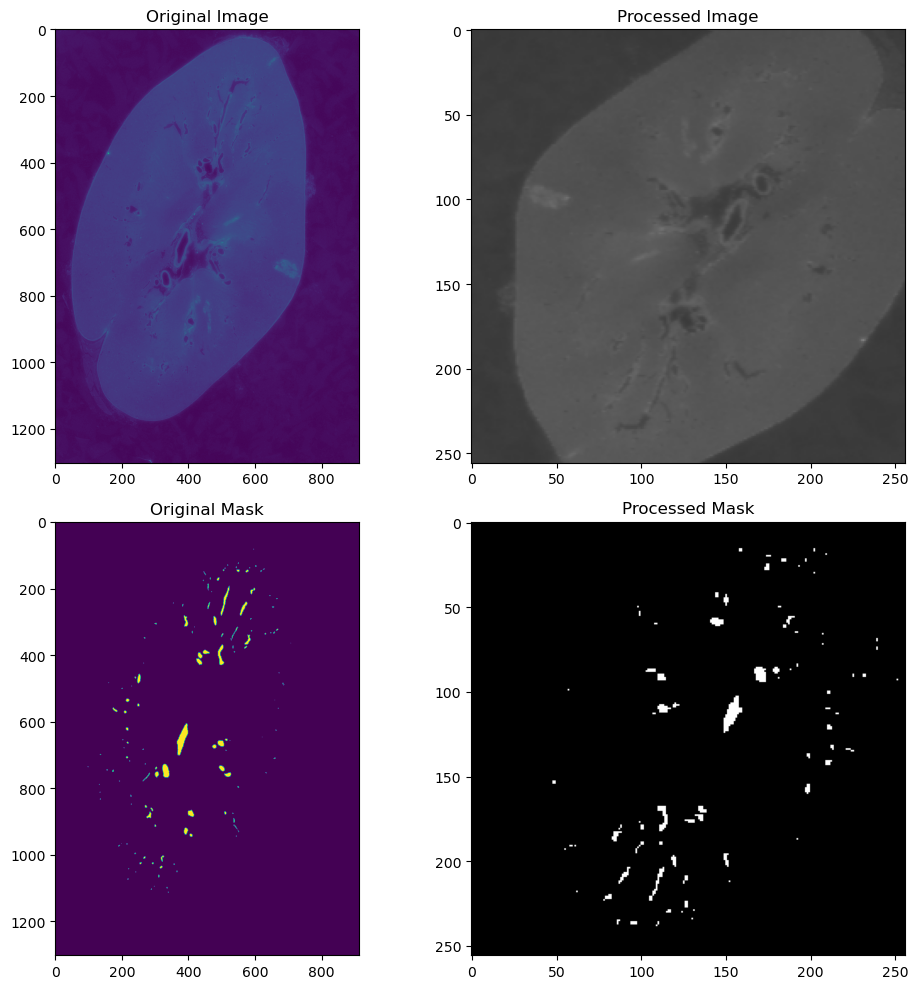

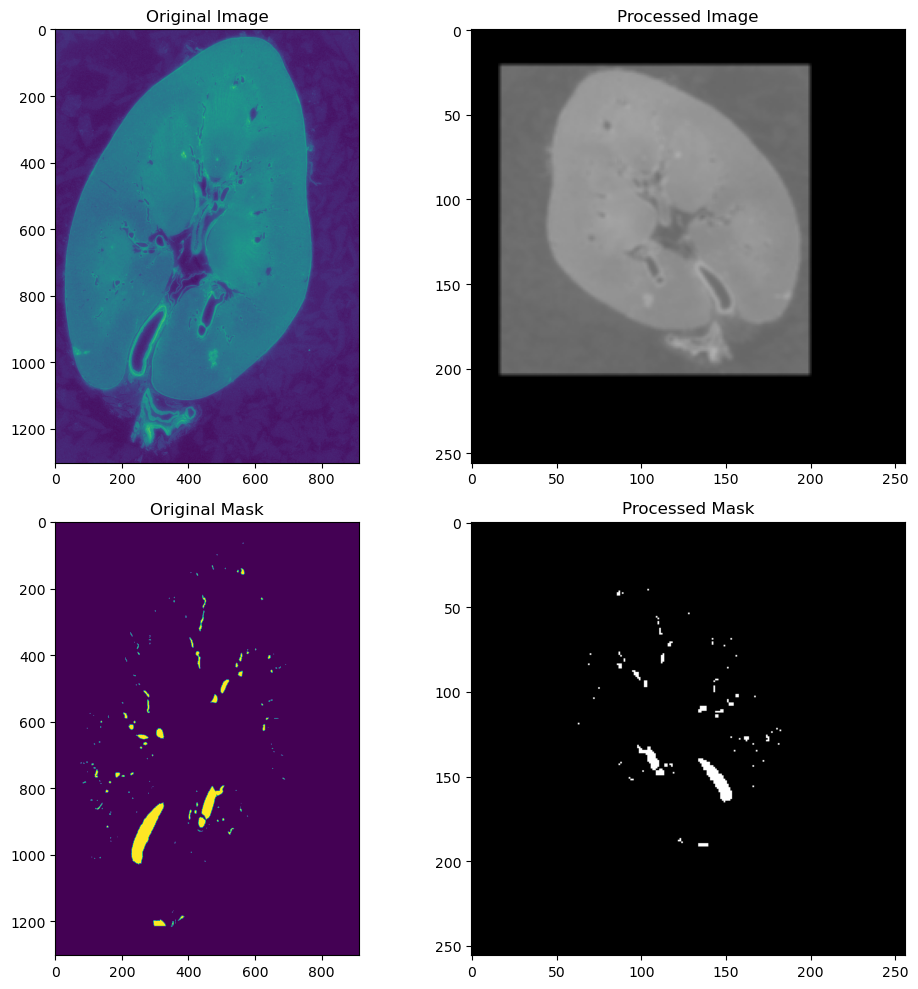

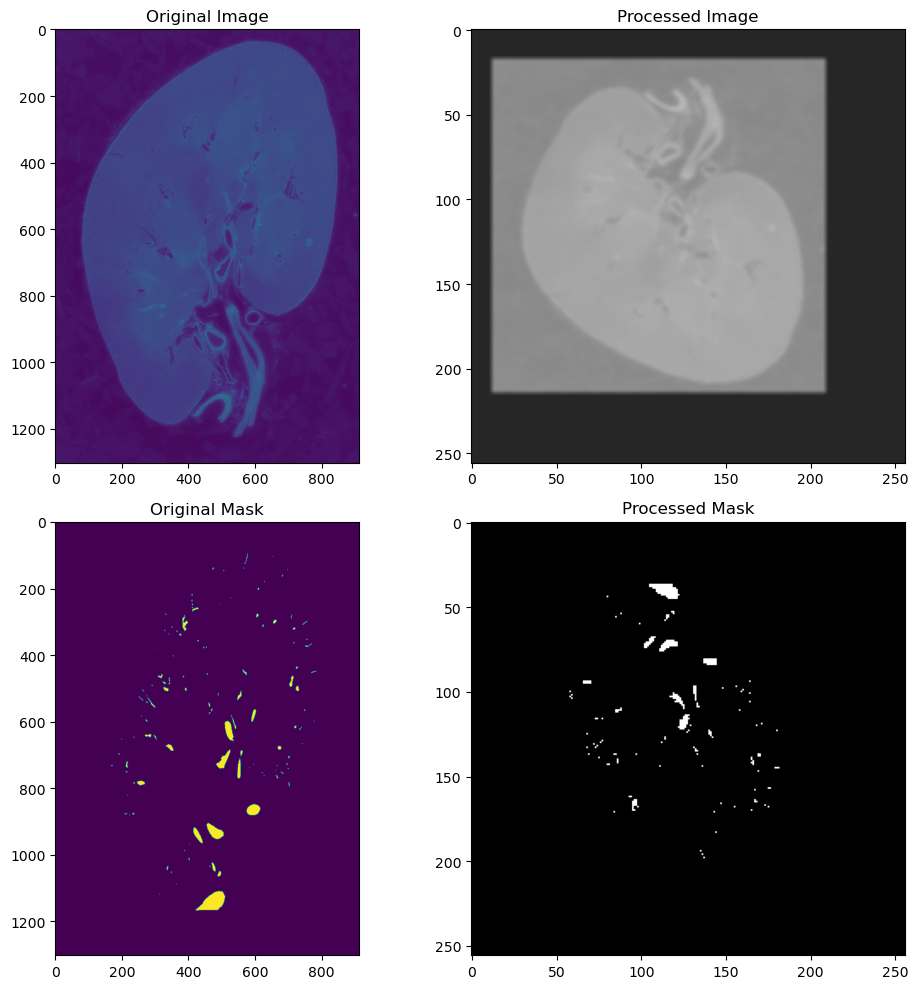

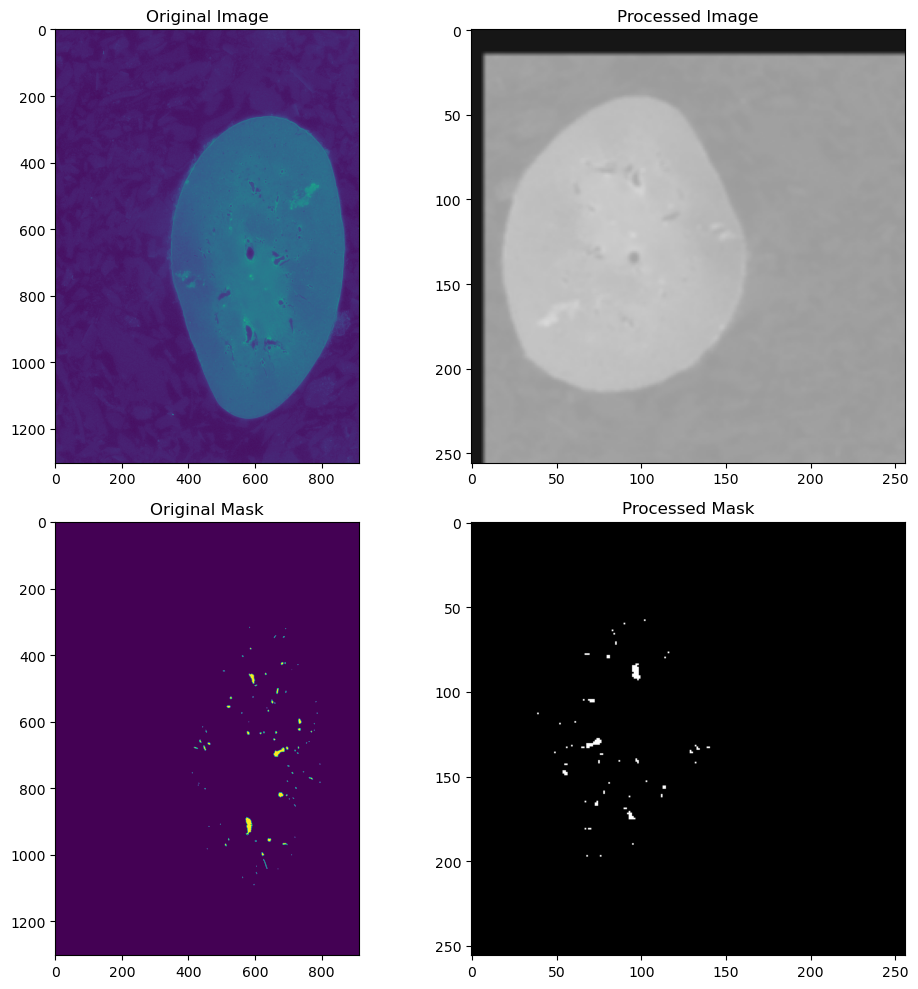

In [8]:
for images, masks, paths in dataloader:
    for image, mask, path in zip(images, masks, paths):
        image = image.permute((1, 2, 0)).numpy() * 255.0
        image = image.astype('uint8')
        mask = (mask*255).numpy().astype('uint8')
        
        # print(path)
        plt.figure(figsize=(10, 10))

        plt.subplot(2, 2, 1)
        plt.imshow(mpimg.imread(path))
        plt.title('Original Image')

        plt.subplot(2, 2, 2)
        plt.imshow(image, cmap='gray')
        plt.title('Processed Image')

        plt.subplot(2, 2, 3)
        plt.imshow(mpimg.imread(path.replace('images', 'labels')))
        plt.title('Original Mask')
        
        plt.subplot(2, 2, 4)
        plt.imshow(mask, cmap='gray')
        plt.title('Processed Mask')

        plt.tight_layout()
        plt.show()
    break

## Model: Attention U-Net

In [9]:
class ConvBlock(nn.Module):
    '''
    A convolutional block consisting of two convolutional layers, each followed by batch normalization and a ReLU activation function.

    Args:
        in_channels (int): Number of channels in the input tensor.
        out_channels (int): Number of channels produced by the convolutional layers.
    
    Attributes:
        conv (nn.Sequential): Sequential container of convolutional layers, batch normalization, and ReLU activation.
    '''

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.conv(x)
        return x

class UpConv(nn.Module):
    '''
    An upsampling block that increases the spatial dimensions of the input tensor using bilinear upsampling, followed by a convolutional layer.

    Args:
        in_channels (int): Number of channels in the input tensor.
        out_channels (int): Number of channels produced by the convolutional layer.

    Attributes:
        up (nn.Sequential): Sequential container for upsampling and convolutional layer.
    '''

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(UpConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.up(x)
        return x

class AttentionBlock(nn.Module):
    '''
    An attention block that computes attention coefficients to enhance feature representation from skip connections in U-Net architecture.

    Args:
        prev_layer (int): Number of feature maps in the gating signal from the previous layer.
        encoder_layer (int): Number of feature maps in the corresponding encoder layer transferred via the skip connection.
        coef (int): Number of learnable multi-dimensional attention coefficients.
    
    Attributes:
        gate (nn.Sequential): Sequential container for processing the gating signal.
        trans (nn.Sequential): Sequential container for processing the feature maps from the skip connection.
        psi (nn.Sequential): Sequential container for computing the final attention coefficients.
        relu (nn.ReLU): ReLU activation function.
    '''

    def __init__(self, prev_layer: int, encoder_layer: int, coef: int) -> None:
        super(AttentionBlock, self).__init__()
        self.gate = nn.Sequential(
            nn.Conv2d(prev_layer, coef, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(coef)
        )
        self.trans = nn.Sequential(
            nn.Conv2d(encoder_layer, coef, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(coef)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(coef, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, prev_gate: torch.Tensor, skip_connection: torch.Tensor) -> torch.tensor:
        '''
        Args:
            gate (torch.Tensor): Signal from previous layer.
            skip_connection (torch.Tensor): Activation from corresponding encoder layer.
        
        Return:
            (torch.Tensor): Output activations.
        '''

        g = self.gate(prev_gate)
        x = self.trans(skip_connection)
        psi = self.relu(g + x)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out

class AttentionUNet(nn.Module):
    '''
    An Attention U-Net architecture for biomedical image segmentation, incorporating attention blocks to focus on important features.

    Args:
        input_ch (int, optional): Number of channels in the input image. Default is 3 for RGB images.
        output_ch (int, optional): Number of channels in the output tensor. Default is 1 for binary segmentation.

    Attributes:
        MaxPool (nn.MaxPool2d): Max pooling layer to reduce spatial dimensions.
        Conv1, Conv2, Conv3, Conv4, Conv5, Conv6 (ConvBlock): Convolutional blocks for the encoder part of U-Net.
        Up6, Up5, Up4, Up3, Up2 (UpConv): Upsampling blocks for the decoder part of U-Net.
        Att6, Att5, Att4, Att3, Att2 (AttentionBlock): Attention blocks to refine skip connections.
        UpConv6, UpConv5, UpConv4, UpConv3, UpConv2 (ConvBlock): Convolutional blocks for merging upsampled features and skip connections.
        Conv (nn.Conv2d): Final convolutional layer to produce the segmentation map.
    '''

    def __init__(self, input_ch: int=3, output_ch: int=1) -> None:
        super(AttentionUNet, self).__init__()
        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        self.Conv1 = ConvBlock(input_ch, 32)
        self.Conv2 = ConvBlock(32, 64)
        self.Conv3 = ConvBlock(64, 128)
        self.Conv4 = ConvBlock(128, 256)
        self.Conv5 = ConvBlock(256, 512)
        self.Conv6 = ConvBlock(512, 1024)

        # Decoder
        self.Up6 = UpConv(1024, 512)
        self.Att6 = AttentionBlock(prev_layer=512, encoder_layer=512, coef=256)
        self.UpConv6 = ConvBlock(1024, 512)

        self.Up5 = UpConv(512, 256)
        self.Att5 = AttentionBlock(prev_layer=256, encoder_layer=256, coef=128)
        self.UpConv5 = ConvBlock(512, 256)

        self.Up4 = UpConv(256, 128)
        self.Att4 = AttentionBlock(prev_layer=128, encoder_layer=128, coef=64)
        self.UpConv4 = ConvBlock(256, 128)

        self.Up3 = UpConv(128, 64)
        self.Att3 = AttentionBlock(prev_layer=64, encoder_layer=64, coef=32)
        self.UpConv3 = ConvBlock(128, 64)
        
        self.Up2 = UpConv(64, 32)
        self.Att2 = AttentionBlock(prev_layer=32, encoder_layer=32, coef=16)
        self.UpConv2 = ConvBlock(64, 32)

        # Output layer
        self.Conv = nn.Conv2d(32, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x: torch.tensor) -> torch.tensor:
        '''
        e: Encoder layers.
        d: Decoder layers.
        s: Skip-connections from encoder layers to decoder layers.
        '''

        # Encoder pathway
        e1 = self.Conv1(x)
        e2 = self.Conv2(self.MaxPool(e1))
        e3 = self.Conv3(self.MaxPool(e2))
        e4 = self.Conv4(self.MaxPool(e3))
        e5 = self.Conv5(self.MaxPool(e4))
        e6 = self.Conv6(self.MaxPool(e5))


        # Decoder pathway
        d6 = self.Up6(e6)
        s5 = self.Att6(prev_gate=d6, skip_connection=e5)
        d6 = torch.cat((s5, d6), dim=1) 
        d6 = self.UpConv6(d6)
        
        d5 = self.Up5(d6)
        s4 = self.Att5(prev_gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) 
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(prev_gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(prev_gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(prev_gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        # Output layer
        out = self.Conv(d2)
        return out

## Training and Evaluating

### Define Evaulator
We didn't use this method here, as this is a demo notebook. For actual use, please refer to the `full_project.ipynb`.

In [10]:
def dice_coeff(prediction: torch.Tensor, target: torch.Tensor) -> float:
    '''
    Calculates the Dice coefficient, a measure of overlap between two samples.

    Args:
        prediction (torch.Tensor): The prediction tensor from the model.
        target (torch.Tensor): The ground truth tensor.

    Returns:
        float: The Dice coefficient, ranging from 0 (no overlap) to 1 (perfect overlap).
    '''

    # Convert prediction to a binary mask
    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    # Calculate intersection and union
    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)

    # Small constant to avoid division by zero
    epsilon = 1e-6

    # Calculate and return the Dice coefficient
    result = 2 * inter / (union + epsilon)
    return float(np.mean(result))

### Define Loss (Focal Loss)
We didn't use this method here, as this is a demo notebook. For actual use, please refer to the `full_project.ipynb`.

In [11]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    '''
    Focal Loss, a variant of Cross-Entropy Loss, which adds a factor to down-weight easy examples and focus training on hard negatives.

    Args:
        gamma (float, optional): Focusing parameter to adjust the rate at which easy examples are down-weighted.
                                 When gamma is 0, Focal Loss is equivalent to Binary Cross-Entropy Loss.
                                 The higher the value of gamma, the more focus on hard negatives.
        size_average (bool, optional): By default, the losses are averaged over each loss element in the batch.
                                       If the field size_average is set to False, the losses are instead summed.
        ignore_index (int, optional): Specifies a target value that is ignored and does not contribute to the input gradient.
        reduce (bool, optional): Deprecated (use reduction instead). By default, the losses are averaged or summed over observations for each minibatch.
        balance_param (float, optional): Balancing parameter to balance the positive and negative examples.

    Methods:
        forward(input, target): Compute the loss given input predictions and true targets.
    '''

    def __init__(self, gamma: float = 0, size_average: bool = None, ignore_index: int = -100, reduce: bool = None, balance_param: float = 1.0) -> None:
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        '''
        Forward pass to compute the focal loss.

        Args:
            input (torch.Tensor): Predictions output by the model (before activation).
            target (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: Computed focal loss.
        '''

        # Ensure the input and target shapes are consistent
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        # Calculate binary cross-entropy loss with logits
        logpt = - F.binary_cross_entropy_with_logits(input, target)

        # Calculate the probability of the correct class
        pt = torch.exp(logpt)

        # Apply the focal loss formula
        focal_loss = -((1 - pt) ** self.gamma) * logpt

        # Apply the balance parameter
        balanced_focal_loss = self.balance_param * focal_loss

        return balanced_focal_loss

### Load Pre-trained Model
We don't train the model in this demo notebook. For the actual training method, please refer to the `full_project.ipynb`.

In [12]:
model = AttentionUNet()
model.to(device)
model.load_state_dict(torch.load(MODEL_LOAD, map_location=device))
performance = pd.read_csv(CSV_LOAD)

## Model Performance

### Performance Measures
Displaying actual performance measured during the training process. Please refer to the `full_project.ipynb` for more information.

,Epoch,Train Loss,Test Loss,Train Dice Coefficient,Test Dice Coefficient
0,1,0.644295,0.410460,7.241753e-04,0.000037
1,2,0.209482,0.109306,2.869641e-05,0.000000
2,3,0.082485,0.055938,0.000000e+00,0.000000
3,4,0.039113,0.028174,0.000000e+00,0.000000
4,5,0.021146,0.015069,6.223825e-07,0.000000
5,6,0.012557,0.009644,2.704820e-05,0.000000
6,7,0.007859,0.005978,6.113442e-04,0.000242
7,8,0.005113,0.004279,2.052094e-02,0.060541
8,9,0.003410,0.003027,2.975069e-01,0.518900
9,10,0.002348,0.002023,5.200892e-01,0.584016


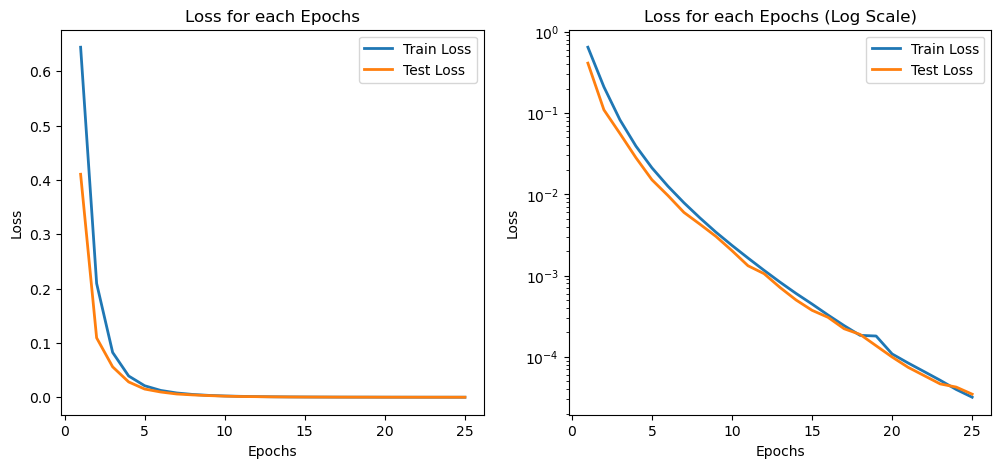

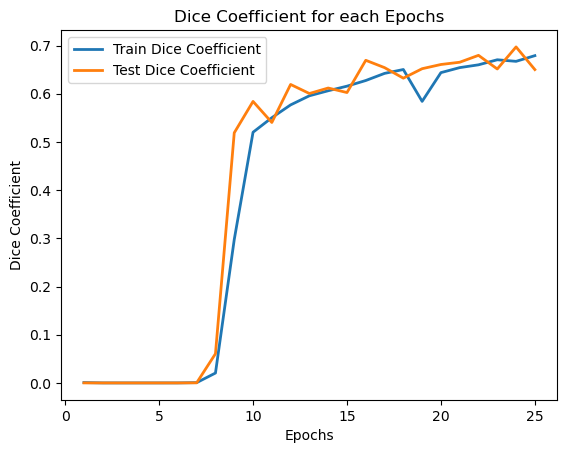

Min Train Loss: 0.0000 (Epoch: 25)
Min Test Loss: 0.0000 (Epoch: 25)
Best Train Dice Coefficient: 0.6790 (Epoch: 25)
Best Test Dice Coefficient: 0.6971 (Epoch: 24)


In [13]:
display(performance)

figure, axis = plt.subplots(1, 2, figsize=(12, 5))
axis[0].plot(performance['Epoch'], performance['Train Loss'], label='Train Loss', lw=2)
axis[0].plot(performance['Epoch'], performance['Test Loss'], label='Test Loss', lw=2)
axis[0].legend()
axis[0].set_ylabel('Loss')
axis[0].set_xlabel('Epochs')
axis[0].set_title('Loss for each Epochs')

axis[1].semilogy(performance['Epoch'], performance['Train Loss'], label='Train Loss', lw=2)
axis[1].semilogy(performance['Epoch'], performance['Test Loss'], label='Test Loss', lw=2)
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Epochs')
axis[1].set_title('Loss for each Epochs (Log Scale)')
plt.show()

plt.plot(performance['Epoch'], performance['Train Dice Coefficient'], label='Train Dice Coefficient', lw=2)
plt.plot(performance['Epoch'], performance['Test Dice Coefficient'], label='Test Dice Coefficient', lw=2)
plt.legend()
plt.ylabel('Dice Coefficient')
plt.xlabel('Epochs')
plt.title(f'Dice Coefficient for each Epochs')
plt.show()

print(f'Min Train Loss: {np.min(performance["Train Loss"]):.4f} (Epoch: {performance["Epoch"][np.argmin(performance["Train Loss"])]})')
print(f'Min Test Loss: {np.min(performance["Test Loss"]):.4f} (Epoch: {performance["Epoch"][np.argmin(performance["Test Loss"])]})')
print(f'Best Train Dice Coefficient: {np.max(performance["Train Dice Coefficient"]):.4f} (Epoch: {performance["Epoch"][np.argmax(performance["Train Dice Coefficient"])]})')
print(f'Best Test Dice Coefficient: {np.max(performance["Test Dice Coefficient"]):.4f} (Epoch: {performance["Epoch"][np.argmax(performance["Test Dice Coefficient"])]})')

### Examples

/Users/nitro/miniconda3/envs/test/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


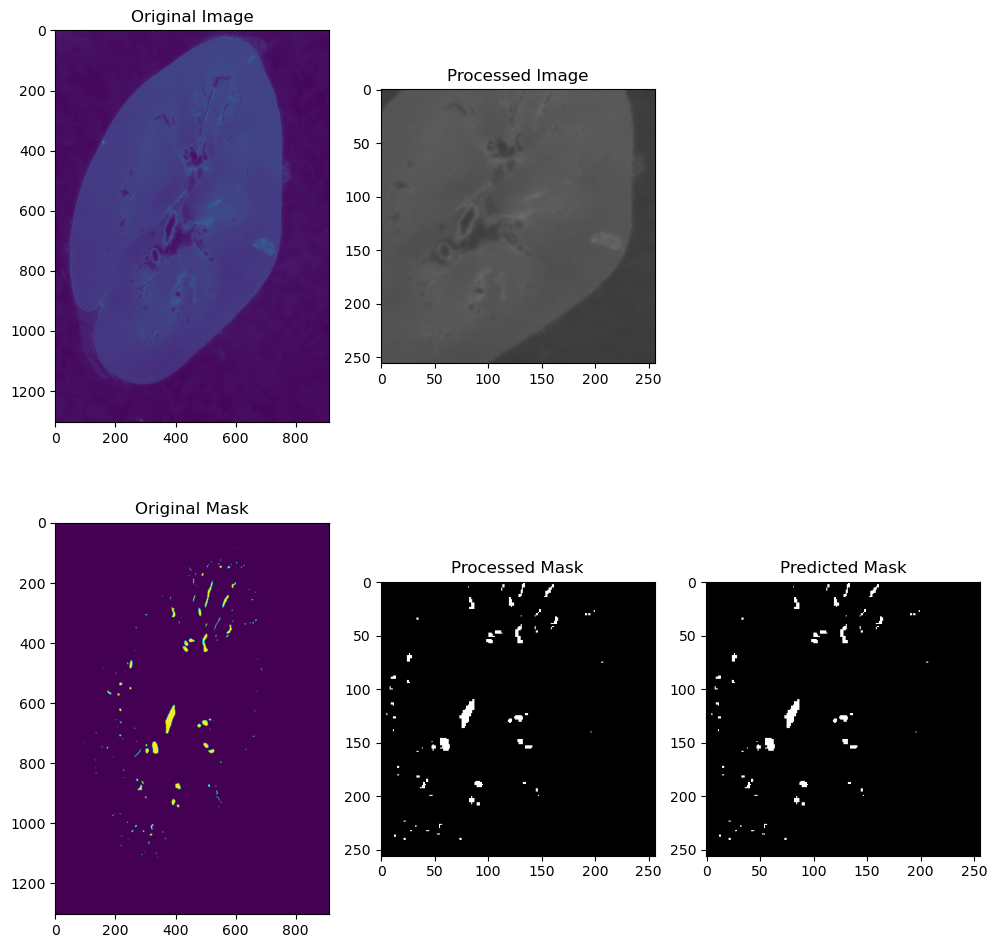

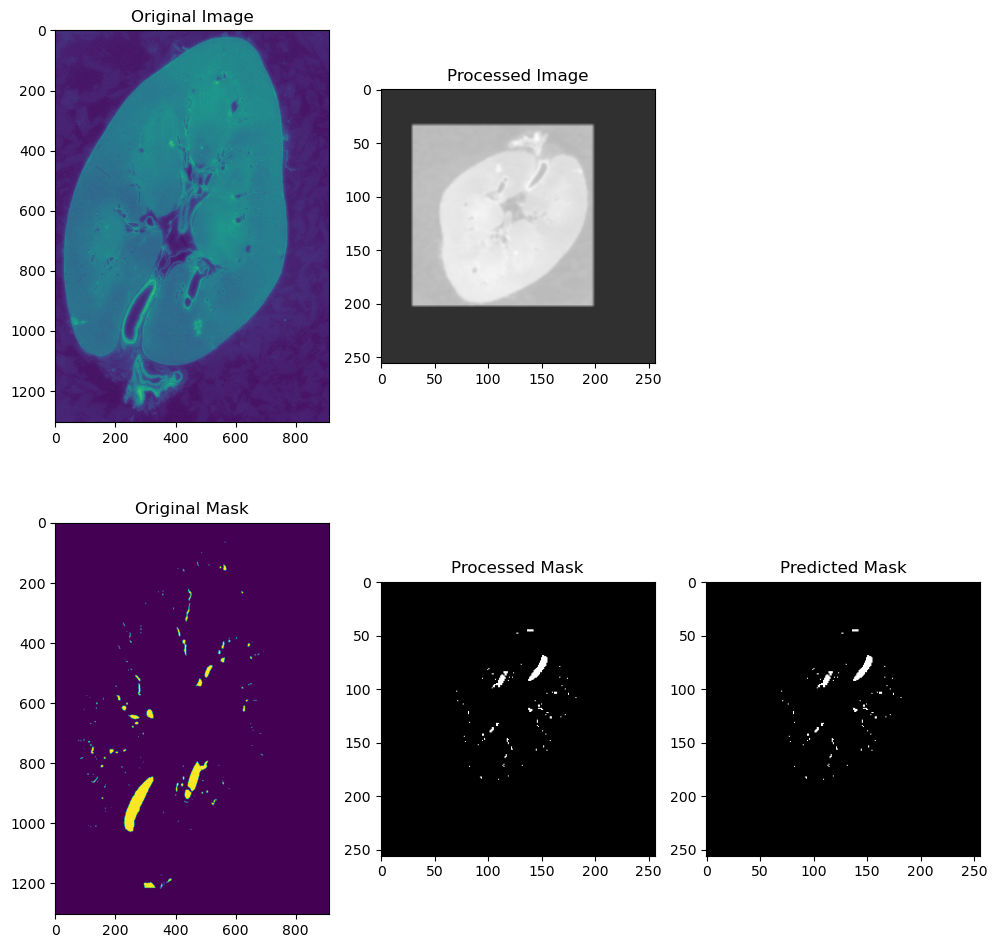

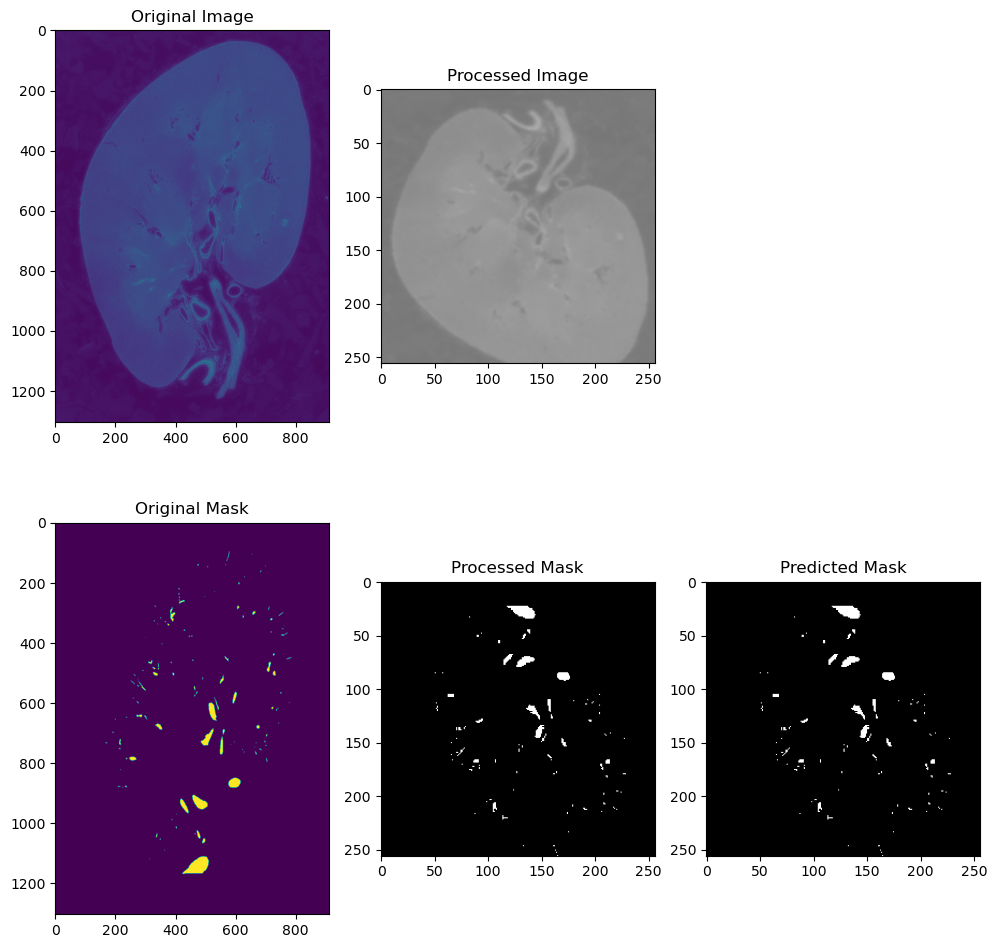

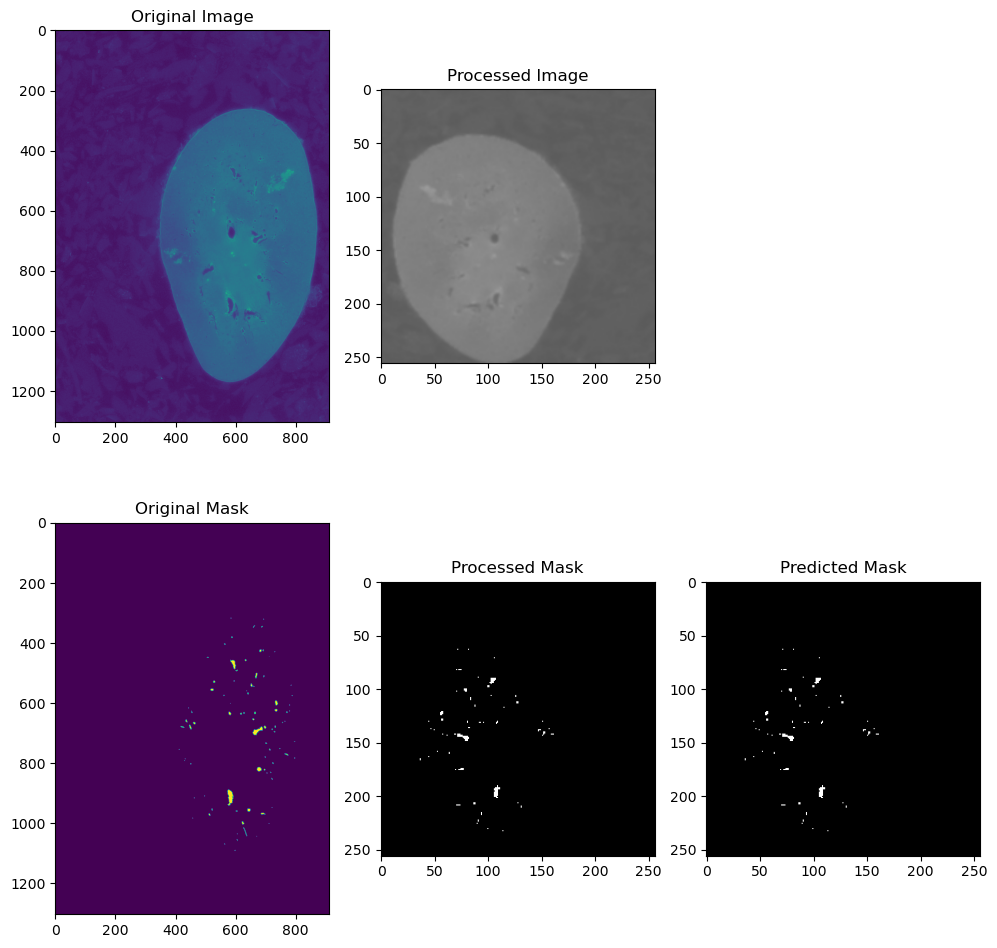

In [14]:
model.eval()
for images, masks, paths in dataloader:
    images = images.to(device)
    outputs = model(images)
    preds = torch.sigmoid(outputs).cpu()
    
    for path, image, mask, pred in zip(paths, images, masks, preds):
        pred_image = pred.detach().numpy().ravel() > 0.5

        image = image.cpu().permute((1, 2, 0)).numpy()*255.0
        image = image.astype('uint8')
        mask = (mask.cpu()*255).numpy().astype('uint8')
        pred = (pred*255).detach().numpy().astype('uint8')

        plt.figure(figsize=(10, 10))

        plt.subplot(2, 3, 1)
        plt.imshow(mpimg.imread(path))
        plt.title('Original Image')

        plt.subplot(2, 3, 2)
        plt.imshow(image, cmap='gray')
        plt.title('Processed Image')

        plt.subplot(2, 3, 4)
        plt.imshow(mpimg.imread(path.replace('images', 'labels')))
        plt.title('Original Mask')
        
        plt.subplot(2, 3, 5)
        plt.imshow(mask, cmap='gray')
        plt.title('Processed Mask')
        
        plt.subplot(2, 3, 6)
        plt.imshow(mask, cmap='gray')
        plt.title('Predicted Mask')

        plt.tight_layout()
        plt.show()
    break